# Sanity check: nutrition dataset with linear models

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution
from linear_evaluation import get_error, get_indirect_effect_flow, get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

np.random.seed(42)

# Dataset and Training

In [2]:
X,y = shap.datasets.nhanesi()

X = X.fillna(X.mean())
y = np.abs(y) # ignore censoring, just do linear regression

X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values
# remove the first column: unnamed: 0
X = X.iloc[:, 1:]
X_display = X_display.iloc[:, 1:]

# training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression().fit(X_train, y_train)

# Explanation settings

In [3]:
nsamples = 100 # paper: 1000 samples
bg = X.fillna(X.mean()).sample(1) # background sample, no need for multiple sample because of the linearity axiom
fg = X[:nsamples] # foreground samples to explain

# Build a causal graph

In [4]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted hazard'
feature_names = list(X.columns)
f = model.predict

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f)) # the target uses log(HR) instead of HR
A = ['Diastolic BP', 'Systolic BP']
D = ['Pulse pressure'] # Systolic BP - Diastolic BP
causal_links.add_causes_effects(A, D, lambda dbp, sdp: sdp-dbp)
A = ['Age', 'Sex', 'Poverty index', 'Race']
D = list(set(feature_names) - set(A) - set(['Pulse pressure']))
causal_links.add_causes_effects(A, D)
A = ['Age', 'Sex', 'Race']
D = ['Poverty index']
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

learning dependency for TIBC: 100%|██████████| 14/14 [00:00<00:00, 123.98it/s]              


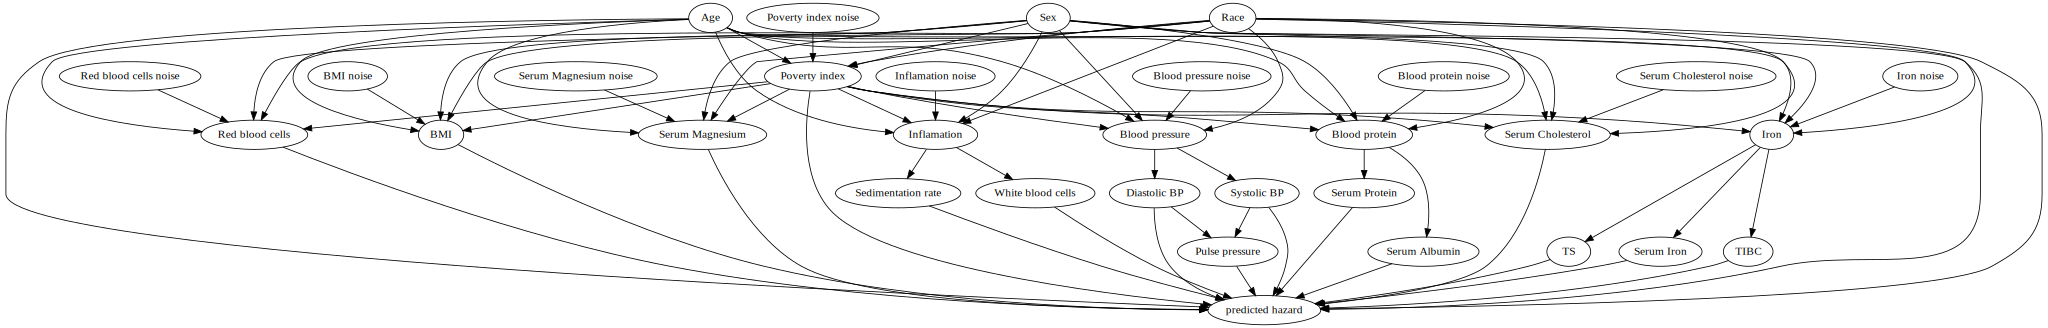

In [5]:
E = GraphExplainer(causal_graph, bg)
E.prepare_graph(fg) # add noise node
G = copy.deepcopy(E.graph)
G = group_nodes(G, [n for n in G if n.name in ['White blood cells', 'Sedimentation rate']], 'Inflamation')
G = group_nodes(G, [n for n in G if n.name in ['Systolic BP', 'Diastolic BP']], 'Blood pressure')
G = group_nodes(G, [n for n in G if n.name in ['TS', 'TIBC', 'Serum Iron']], 'Iron')
G = group_nodes(G, [n for n in G if n.name in ['Serum Protein', 'Serum Albumin']], 'Blood protein')
G.draw()

# Explain

Flow, ASV, and SHAP converge in 1 run b/c the model is linear.

In [6]:
cf_flow_nutrition = GraphExplainer(G, bg, nruns=1).shap_values(fg, skip_prepare=True)

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


In [7]:
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence
explainer = OnManifoldExplainer(f, pd.concat([bg, bg_on_manifold]), nruns=100, sigma_sq=0.1) # need > 1 run b/c conditional expectation is non-linear
cf_on_manifold_nutrition = explainer.shap_values(fg)

manifold bg samples: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


In [8]:
explainer = IndExplainer(f, bg, nruns=1)
cf_ind_nutrition = explainer.shap_values(fg)

100%|██████████| 1/1 [00:00<00:00, 287.71it/s]


# Compare baselines

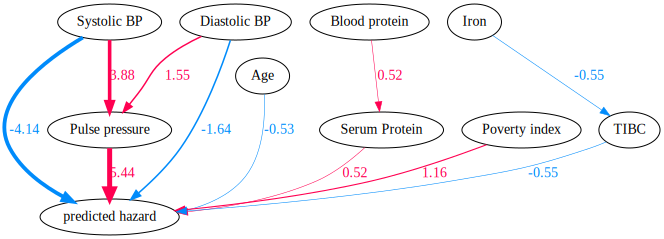

<AGraph <Swig Object of type 'Agraph_t *' at 0x7efe383a0f60>>

In [9]:
sample_ind = 99
cf_flow_nutrition.draw(sample_ind, max_display=10, show_fg_val=False)

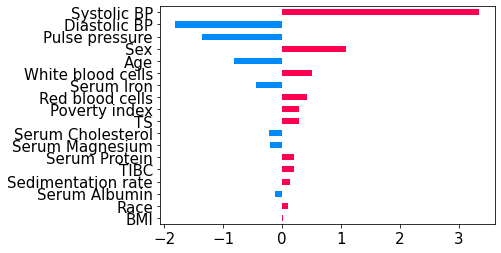

In [10]:
cf_on_manifold_nutrition.draw(sample_ind)

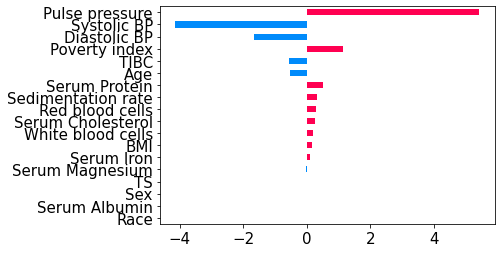

In [11]:
cf_ind_nutrition.draw(sample_ind)

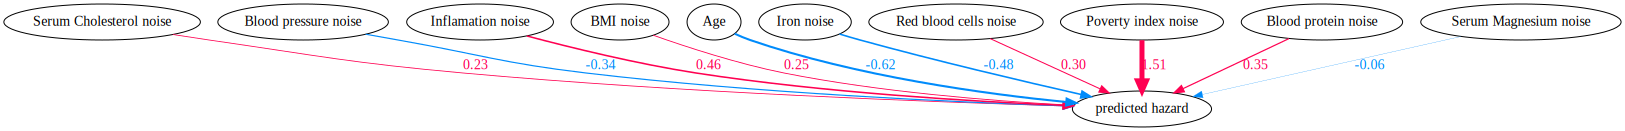

In [12]:
# ASV
cf_flow_nutrition.fold_noise = False
g = cf_flow_nutrition.draw_asv(sample_ind, max_display=10, show_fg_val=False)

# Calculate difference with the ground truth

In [13]:
gt = get_direct_effect_ground_truth(cf_flow_nutrition.graph)
theta_ind = get_effect_ind(cf_ind_nutrition)
theta_manifold = get_effect_manifold(cf_on_manifold_nutrition)
theta_asv = get_effect_asv(cf_flow_nutrition)
theta_flow = get_direct_effect_flow(cf_flow_nutrition)

gt_indirect = get_indirect_effect_ground_truth(cf_flow_nutrition.graph)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_nutrition)

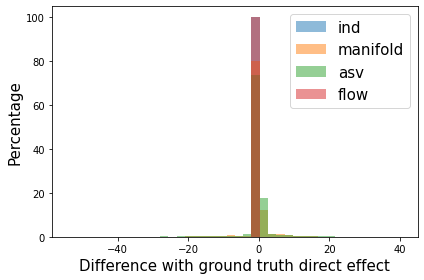

       ind: 0.0 ($\pm$ 0.0)
  manifold: 0.9 ($\pm$ 3.0)
       asv: 1.2 ($\pm$ 3.9)
      flow: 0.0 ($\pm$ 0.0)


In [15]:
errors = {
    'ind': get_error(gt, theta_ind),
    'manifold': get_error(gt, theta_manifold),
    'asv': get_error(gt, theta_asv),
    'flow': get_error(gt, theta_flow)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] # get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

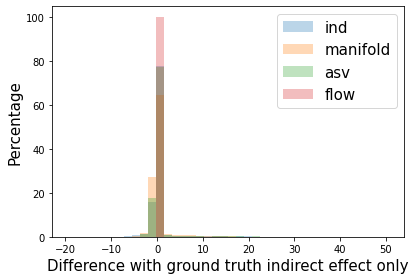

       ind: 0.8 ($\pm$ 3.1)
  manifold: 0.8 ($\pm$ 2.0)
       asv: 0.6 ($\pm$ 2.3)
      flow: 0.0 ($\pm$ 0.0)


In [16]:
errors = {
    'ind': get_error(gt_indirect, theta_ind),
    'manifold': get_error(gt_indirect, theta_manifold),
    'asv': get_error(gt_indirect, theta_asv),
    'flow': get_error(gt_indirect, theta_flow_indirect)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.3, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect only', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

Only Shapley Flow makes no mistake on both the direct and indirect effects.